In [1]:
### preparation:
#  pip install git+https://github.com/peijin94/FastQSL

import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy,tqdm # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime


time: 0 ns (started: 2023-07-01 19:28:09 +03:00)


In [2]:
import fastqslpy
from fastqslpy import FastQSL
TraceAllBline = fastqslpy.kernels.compileTraceBlineRK4()

compiling kernel
c:\Users\Pjer1\anaconda3\lib\site-packages\fastqslpy
c:\Users\Pjer1\anaconda3\lib\site-packages\fastqslpy\kernels.py
c:\Users\Pjer1\anaconda3\lib\site-packages\fastqslpy\cu
time: 6.16 s (started: 2023-07-01 19:28:10 +03:00)


In [3]:
a = sciIO.readsav(r'D:\\vult\calc_data\QSL\TD1.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg', 'yreg', 'zreg', 'resolution', 'dir'])
time: 47 ms (started: 2023-07-01 19:28:19 +03:00)


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.bx,(2,1,0))
By = np.transpose(a.by,(2,1,0))
Bz = np.transpose(a.bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

time: 0 ns (started: 2023-07-01 19:28:22 +03:00)


In [5]:
Bz.shape

(251, 251, 251)

time: 15 ms (started: 2023-07-01 19:28:24 +03:00)


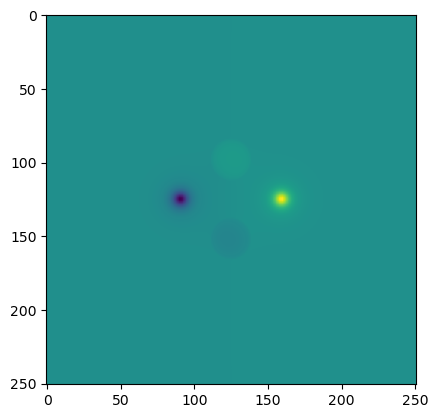

time: 203 ms (started: 2023-07-01 19:28:24 +03:00)


In [6]:
plt.imshow(Bz[:,:,3].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [7]:
np.mean(np.abs((Bx)))

0.01556248

time: 47 ms (started: 2023-07-01 19:28:25 +03:00)


In [8]:
vec = np.array([1.01,2.01,5.01])
vec[vec<=0]=1e-9
vec[vec>=Bx.shape]=(np.array(Bx.shape)-1e-9)[vec>=Bx.shape]

time: 0 ns (started: 2023-07-01 19:28:26 +03:00)


In [9]:
Bx_gpu.shape

(0,)

time: 0 ns (started: 2023-07-01 19:28:26 +03:00)


In [10]:

(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False

time: 0 ns (started: 2023-07-01 19:28:26 +03:00)


In [11]:
if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)
    
dummy=cupy.zeros([1,1],dtype=cupy.float32)
dummy64=cupy.zeros([1,1],dtype=cupy.float64)
flag_twist=cupy.array([True],dtype=cupy.bool_)
flag_twist_false=cupy.array([False],dtype=cupy.bool_)

xfull =np.arange(Bx.shape[0])
yfull =np.arange(Bx.shape[1])
zfull =np.arange(Bx.shape[2])
Bx_gpu.shape



transfering B-field to GPU


(251, 251, 251)

time: 125 ms (started: 2023-07-01 19:28:27 +03:00)


In [12]:
# calc curl(B)
curBx_gpu = cupy.zeros_like(Bx_gpu)
curBy_gpu = cupy.zeros_like(By_gpu)
curBz_gpu = cupy.zeros_like(Bz_gpu)

curBx_gpu[:,1:-1,1:-1] = ((Bz_gpu[:,2:,  1:-1]-Bz_gpu[:,0:-2,1:-1])/2.
                         -(By_gpu[:,1:-1,2:]-  By_gpu[:,1:-1,0:-2])/2)
curBy_gpu[1:-1,:,1:-1] = ((Bx_gpu[1:-1,:,2:]-  Bx_gpu[1:-1,:,0:-2])/2.
                         -(Bz_gpu[2:,  :,1:-1]-Bz_gpu[0:-2,:,1:-1])/2)
curBz_gpu[1:-1,1:-1,:] = ((By_gpu[2:,  1:-1,:]-By_gpu[0:-2,1:-1,:])/2.
                         -(Bx_gpu[1:-1,2:,  :]-Bx_gpu[1:-1,0:-2,:])/2)

# take care of z=0
curBx_gpu[1:-1,1:-1,0] = ((Bz_gpu[1:-1,2:,  0]-Bz_gpu[1:-1,0:-2,0])/2.
                         -(-3.*By_gpu[1:-1,1:-1,0]+4.*By_gpu[1:-1,1:-1,1]-By_gpu[1:-1,1:-1,2])/2)
curBy_gpu[1:-1,1:-1,0] = ((-3.*Bx_gpu[1:-1,1:-1,0]+4.*Bx_gpu[1:-1,1:-1,1]-Bx_gpu[1:-1,1:-1,2])/2.
                         -(Bz_gpu[2:,  1:-1,0]-Bz_gpu[0:-2,1:-1,0])/2)

time: 422 ms (started: 2023-07-01 19:28:28 +03:00)


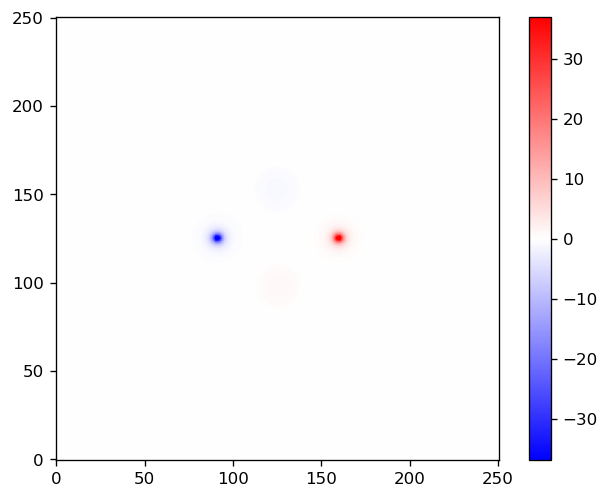

time: 219 ms (started: 2023-07-01 19:28:29 +03:00)


In [13]:
plt.figure(dpi=120)
groundMap=Bz_gpu[:,:,0].get()
plt.imshow(groundMap.T,origin='lower',vmax=np.max(np.abs(groundMap))*0.8,
                                       vmin=-np.max(np.abs(groundMap))*0.8,cmap='bwr')
plt.colorbar()

In [14]:

# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx_gpu.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio
x_range = [100,200]
y_range = [100,200]

#y_range = [50,250]
#x_range = [250,450]
z_range = [0,0.5]
#z_range = [0,1]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
z_i = cupy.linspace(*z_range, np.uint(interp_ratio*(z_range[1]-z_range[0])),dtype=cupy.float32)

x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()

#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1.],cupy.float32)
tol_coef    = cupy.array([cupy.sqrt(1e3)],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

twist_all = cupy.zeros(x_inp.shape,cupy.float64)

# for GTX 1060
blck=(64,1,1)
grd = (20,1)

# for GTX1080ti,P100
blck=(128,1,1)
grd = (56,1)

cupy.cuda.stream.get_current_stream().synchronize()

[251 251 251]
time: 16 ms (started: 2023-07-01 19:28:30 +03:00)


In [15]:
Qube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
Twube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
Liube=np.zeros([xy_shape[1],xy_shape[0],z_i.shape[0]],dtype=np.float32)
#z_i=z_i*0+20

B0cube = np.zeros(x_arr.shape,dtype=np.float32)
Bx_gpu.dtype

dtype('<f4')

time: 15 ms (started: 2023-07-01 19:28:31 +03:00)


In [16]:
pinned_mempool = cupy.get_default_pinned_memory_pool()
for idx_pos_z,z_pos in tqdm.tqdm(enumerate(z_i)):

    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32)+z_pos)
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]

    cupy.cuda.stream.get_current_stream().synchronize()
    # run the big calclation
    
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                curBx_gpu,curBy_gpu,curBz_gpu,twist_all,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, tol_coef))
    
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr,   B_flag_arr, twist_all_arr,
     line_len_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    Bx_start,By_start,Bz_start,
                    Bx_end,By_end,Bz_end, 
                    Bx_inp,By_inp,Bz_inp,B_flag,twist_all,line_len)
    
    if z_pos<1e-5:
        B0cube=Bz_0_arr.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,    
         B_flag_arr, stride_step)
    stride_this  =  cupy.float32(1./interp_ratio)/8

    
    (cut_inp_x,   cut_inp_y,   cut_inp_z,
        cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
        cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
        Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
        Bx_start_cut,By_start_cut,Bz_start_cut,
        Bx_end_cut,  By_end_cut,  Bz_end_cut,  
        N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
             x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bz_0_arr,    B_flag_arr, stride_this)
    
    cupy.cuda.stream.get_current_stream().synchronize()
    TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
              dummy,dummy,dummy,dummy64,flag_twist_false,
            cut_inp_x,   cut_inp_y,   cut_inp_z,inp_norm,
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
    
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    cupy.cuda.stream.get_current_stream().synchronize()
    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];
    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];
    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0
    
    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)
    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    
    Qube[:,:,idx_pos_z]=Q_all.T.get()
    Twube[:,:,idx_pos_z]=twist_all_arr.T.get()
    Liube[:,:,idx_pos_z]=line_len_arr.T.get()
    
    cupy.cuda.stream.get_current_stream().synchronize()
    
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]
    pinned_mempool.free_all_blocks()

2it [00:01,  1.88it/s]

time: 1.08 s (started: 2023-07-01 19:28:32 +03:00)


C:\Users\Pjer1\AppData\Local\Temp\ipykernel_69208\1190804685.py:1: RuntimeWarning: divide by zero encountered in log
  Q0 = np.log(Qube[:,:,0]).T


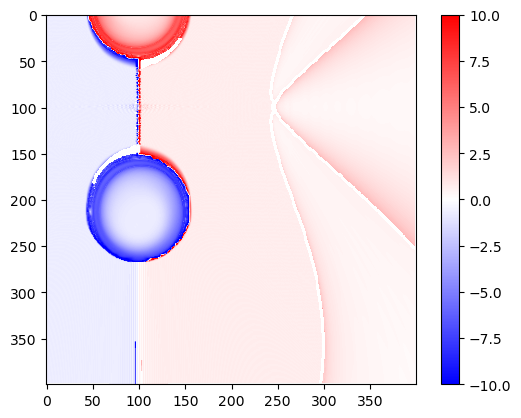

time: 266 ms (started: 2023-07-01 19:28:33 +03:00)


In [17]:
Q0 = np.log(Qube[:,:,0]).T
Q0[Q0>1e15]=0
Q0[Q0<-1e15]=0

plt.imshow((Q0)*np.sign(B0cube),vmax=10,
                                       vmin=-10,cmap='bwr')
plt.colorbar()

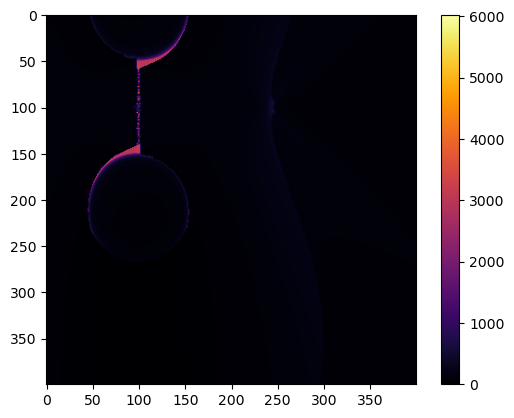

time: 297 ms (started: 2023-07-01 19:28:45 +03:00)


In [18]:
Q0 = (Liube[:,:,0]).T
Q0[Q0>1e15]=0
Q0[Q0<-1e15]=0

plt.imshow((Q0),vmax=np.nanmax(np.abs(Q0)),
                                       vmin=0,cmap='inferno')
plt.colorbar()

<ipython-input-21-227847c10dc6>:49: RuntimeWarning: divide by zero encountered in log
  img = ax.imshow(np.log(d**2),vmax=0,vmin=-5,cmap='bwr',origin='lower')


Text(0.5, 1.0, 'flag histogram')

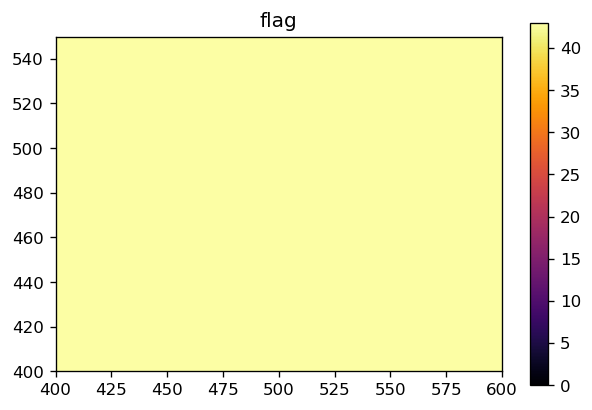

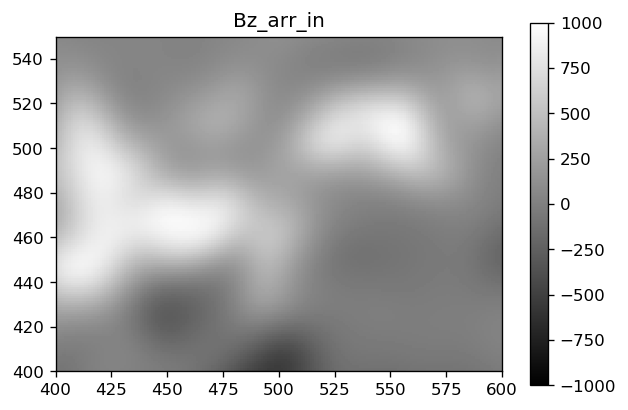

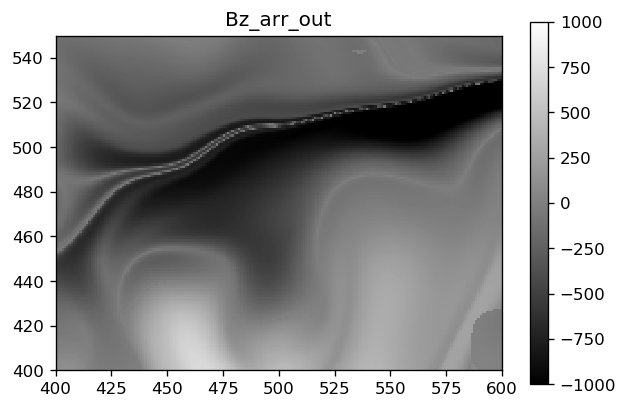

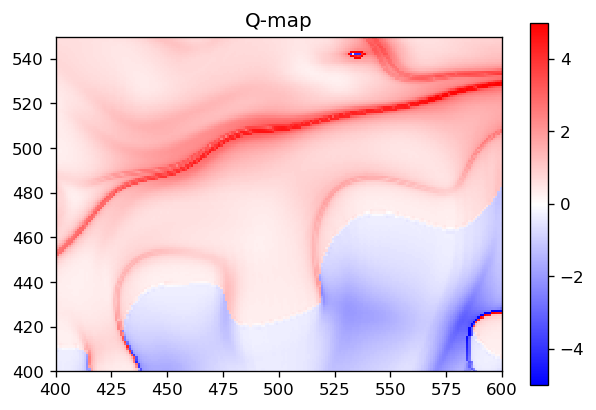

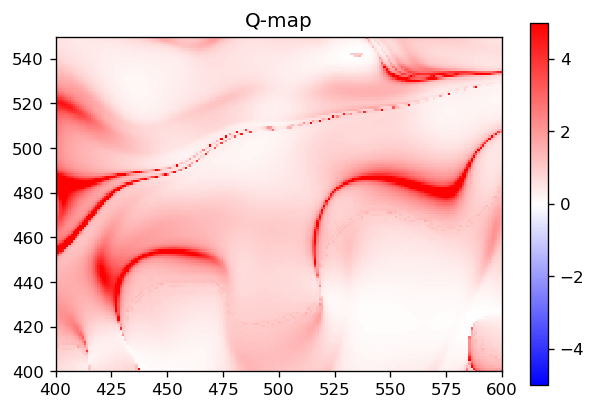

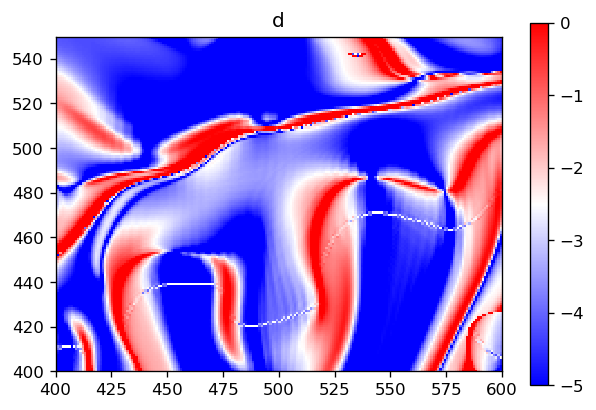

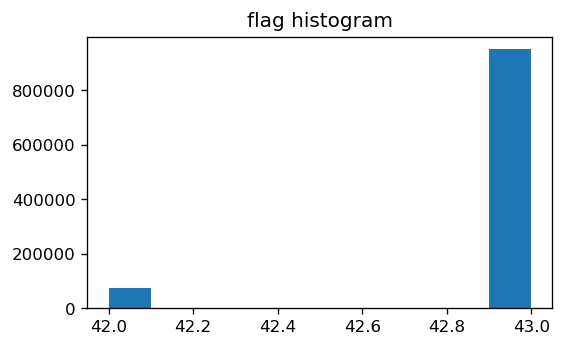

time: 2.59 s


In [21]:
plt.close()

xxlim=[400,600]
yylim=[400,550]

fig=plt.figure(0,dpi=120); ax = plt.gca() 
img=ax.imshow(flag_out.get().reshape(xy_shape),cmap='inferno',origin='lower',vmin=0)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

#fig=plt.figure(1,dpi=120); ax = plt.gca() 
#img=ax.imshow(line_len.get().reshape(xy_shape),cmap='inferno',origin='lower')
#fig.colorbar(img)
#ax.set_title('Length of B-line')
#ax.set_xlim(xxlim)
#ax.set_ylim(yylim)

fig=plt.figure(2,dpi=120); ax = plt.gca() 
img=ax.imshow(Bz_arr_in,cmap='gray',origin='lower',vmax=1000,vmin=-1000)
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=120); ax = plt.gca() 
img=ax.imshow(Bz_arr_out,cmap='gray',origin='lower',vmax=1000,vmin=-1000)
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=120); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*np.sign(Bz_arr_in[1:-1,1:-1])*(flags_arr[1:-1,1:-1]<np.inf),vmax=5,vmin=-5,cmap='bwr',origin='lower')
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(5,dpi=120); ax = plt.gca() 
img = ax.imshow(np.abs(Bz_arr_in[1:-1,1:-1]/Bz_arr_out[1:-1,1:-1]),vmax=5,vmin=-5,cmap='bwr',origin='lower')
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(6,dpi=120); ax = plt.gca() 
img = ax.imshow(np.log(d**2),vmax=0,vmin=-5,cmap='bwr',origin='lower')
fig.colorbar(img)
ax.set_title('d')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_out.get())
ax.set_title('flag histogram')


<ipython-input-19-63dcd14ad29e>:2: RuntimeWarning: divide by zero encountered in log
  img = ax.imshow(np.log((d)**2),cmap='inferno',origin='lower',vmax=0.3,vmin=-40,extent=[*x_range,*y_range])


(400, 550)

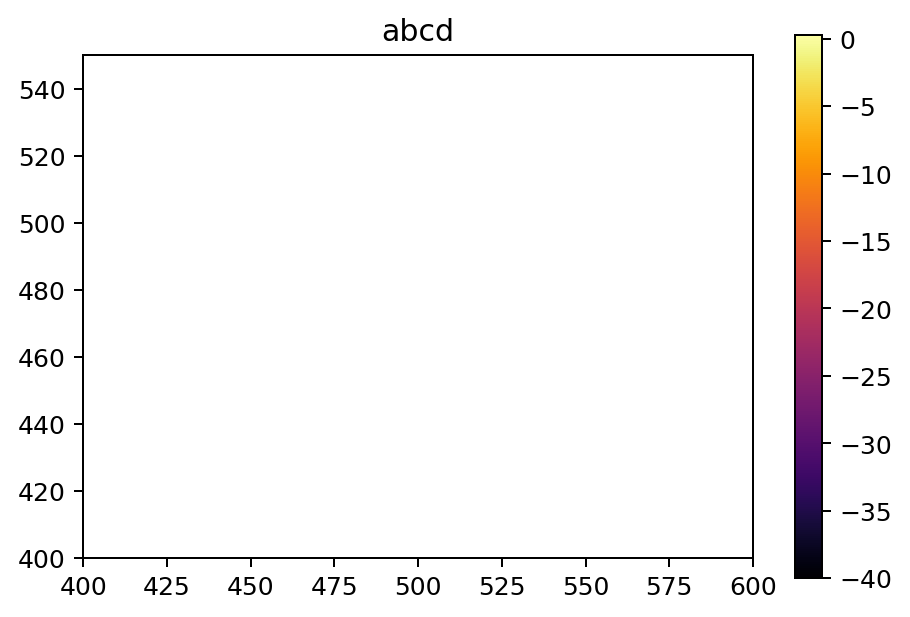

time: 428 ms


In [19]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
img = ax.imshow(np.log((d)**2),cmap='inferno',origin='lower',vmax=0.3,vmin=-40,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
